In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math

# Prevent Python from generating .pyc files (compiled bytecode files)
sys.dont_write_bytecode = True

# Import necessary modules and configuration settings
from prompts import *
from model import *
from utils import *

INFO 12-02 15:14:09 [__init__.py:243] Automatically detected platform cuda.


In [2]:
# Contains the generated Synonyms of HPO Concepts per Round.
generated = pd.read_csv(outputFileGenerated)
# Contains Labels and Synonyms of HPO Concepts.
gold = pd.read_csv(outputFileGold)
print(len(generated.index))
print(len(gold.index))

153
50


In [3]:
# Map system to 1 / 0
systems = list(set(generated[systemColumn].tolist()))
for index, system in enumerate(systems):
    generated[systemColumn] = generated[systemColumn].replace(system, index + 1)

generated[systemColumn] = generated[systemColumn].fillna(0)
generated.loc[generated[systemColumn] == "", systemColumn] = 0
generated[systemColumn] = generated[systemColumn].astype(int)

/tmp/ipykernel_1402417/4235644070.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  generated[systemColumn] = generated[systemColumn].replace(system, index + 1)


In [4]:
[languageColumn, classColumn, hpoidColumn, systemColumn]
generated_counts_per_concept = generated.groupby([languageColumn, classColumn, hpoidColumn, systemColumn]).size().reset_index(name = "dummy")
generated_counts_per_round = generated.groupby([languageColumn, classColumn, hpoidColumn, "round"]).size().reset_index(name = "dummy")

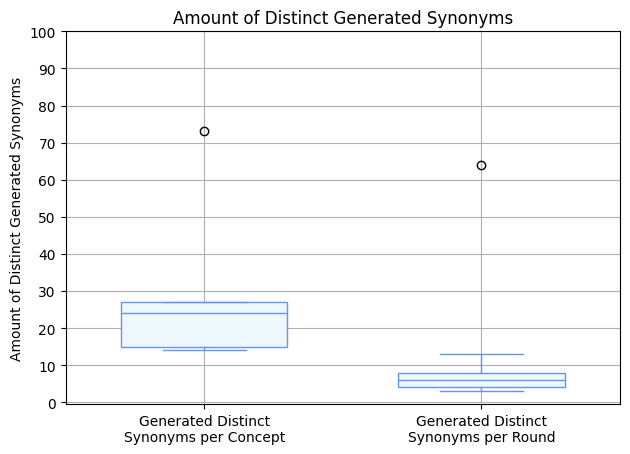

In [5]:
q1 = generated_counts_per_concept["dummy"].quantile([0.25, 0.5, 0.75])
q2 = generated_counts_per_round["dummy"].quantile([0.25, 0.5, 0.75])

q1 = q1.astype(dtype=int)
q2 = q2.astype(dtype=int)

maxDummy1 = generated_counts_per_concept["dummy"].max()
minDummy1 = generated_counts_per_concept["dummy"].min()
maxDummy2 = generated_counts_per_round["dummy"].max()
minDummy2 = generated_counts_per_round["dummy"].min()

combined = pd.DataFrame({
    "value": pd.concat([generated_counts_per_concept["dummy"], generated_counts_per_round["dummy"]]),
    "group": ["Generated Distinct\nSynonyms per Concept"] * len(generated_counts_per_concept) + ["Generated Distinct\nSynonyms per Round"] * len(generated_counts_per_round)
})

yticks = 10
percentage = 0.3
xq1 = 0.15
xq2 = 2.65

combined.boxplot(by="group", column="value", widths = 0.6, patch_artist=True,
    boxprops=dict(facecolor="aliceblue", color="cornflowerblue"),
    medianprops=dict(color="cornflowerblue"),
    whiskerprops=dict(color="cornflowerblue"),
    capprops=dict(color="cornflowerblue"))

plt.title("Amount of Distinct Generated Synonyms")
plt.suptitle("")
plt.xlabel("")
plt.ylabel("Amount of Distinct Generated Synonyms")

plt.yticks(range(0, 105, yticks))
"""
for label, yval in zip(["25%", "50%", "75%"], q1):
    plt.text(xq1, yval, f"{label}: {yval}")

plt.text(xq1, maxDummy1 + yticks * percentage, f"Max: {maxDummy1}")
plt.text(xq1, minDummy1 - yticks * percentage, f"Min: {minDummy1}")

for label, yval in zip(["25%", "50%", "75%"], q2):
    plt.text(xq2, yval, f"{label}: {yval}")

plt.text(xq2, maxDummy2 + yticks * percentage, f"Max: {maxDummy2}")
plt.text(xq2, minDummy2 - yticks * percentage, f"Min: {minDummy2}")
"""
plt.tight_layout()
plt.show()

In [ ]:
def getPercentage(interval: float = 0.1, additional: int = 1) -> list:
    ret = []
    numbers = list(np.arange(0, 1.1, interval))

    for number in numbers:
        ret.append(str(math.floor(100 * number)) + "%")

    for _ in range(0, additional):
        ret.append("")

    return ret

In [7]:
roundCount = max(generated["round"].tolist())
roundSetsCounts = [0] * roundCount
roundSets = [[] for _ in range(0, roundCount)]
roundSetsDiff = [[] for _ in range(0, roundCount)]
roundSetCumulative = [[] for _ in range(0, roundCount)]

for round in range(0, roundCount):
    # Create Sets.
    roundSets[round] = list(set(generated[generated["round"] == round + 1][contentColumn]))
    roundSetsDiff[round] = roundSets[round].copy()
    
    roundSetsCounts[round] = len(roundSets[round])

    # Remove Elements from previous Rounds.
    for prevround in range(0, round):
        roundSetsDiff[round] = list(set(roundSetsDiff[round]).difference(set(roundSets[prevround])))
        roundSetCumulative[round] = list(set(list(roundSetCumulative[round]) + list(roundSets[prevround])))

    roundSetsCounts[round] = len(roundSetsDiff[round]) / roundSetsCounts[round]

roundSetCumulative[0] = roundSets[0]

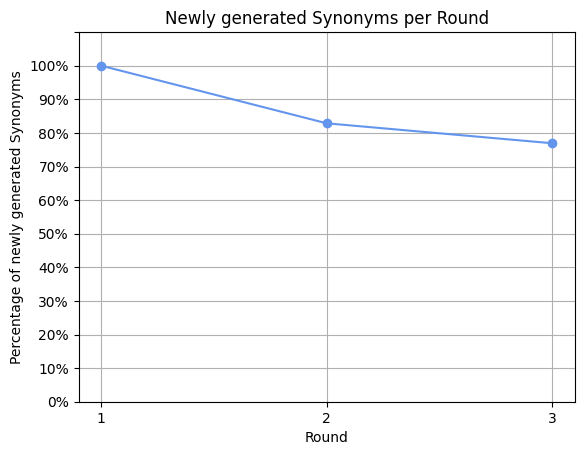

In [8]:
plt.figure()
plt.plot(np.arange(1, roundCount + 1), roundSetsCounts, marker='o', color='cornflowerblue')
plt.yticks(np.arange(0, 1.2, 1 / yticks), getPercentage(1 / yticks))
plt.xticks(np.arange(1, roundCount + 1, 1))
plt.title("Newly generated Synonyms per Round")
plt.xlabel("Round")
plt.ylabel("Percentage of newly generated Synonyms")
plt.grid(True)
plt.show()

In [9]:
goldSet = set(gold[gold[classColumn] == exactSynonymClass][contentColumn])

In [10]:
goldCoverage = [0] * roundCount
goldCumulativeCoverage = [0] * roundCount
goldCoverageAccuracy = [0] * roundCount
goldCoverageJaccard = [0] * roundCount
goldCumulativeCoverageJaccard = [0] * roundCount
goldCumulativeCoverageAccuracy = [0] * roundCount

for index, roundData in enumerate(roundSets):
    # Intersection by only looking at the specific round
    goldCoverage[index]             = list(np.intersect1d(list(roundData), list(goldSet)))

    # Intersection by looking at the specific round an all rounds before.
    goldCumulativeCoverage[index]   = list(np.intersect1d(list(roundSetCumulative[index]), list(goldSet)))

    goldCoverageAccuracy[index]     = len(goldCoverage[index]) / len(goldSet)
    goldCumulativeCoverageAccuracy[index]     = len(goldCumulativeCoverage[index]) / len(goldSet)

    goldCumulativeCoverageJaccard[index]      = len(goldCumulativeCoverage[index]) / len(set(list(goldSet) + list(roundSetCumulative[index])))
    goldCoverageJaccard[index]     = len(goldCoverage[index]) / len(set(list(goldSet) + list(roundSetCumulative[index])))

print(goldCoverageAccuracy)
print(goldCumulativeCoverageAccuracy)
print(goldCumulativeCoverageJaccard)
print(goldCoverageJaccard)

[0.11363636363636363, 0.045454545454545456, 0.045454545454545456]
[0.11363636363636363, 0.11363636363636363, 0.11363636363636363]
[0.03816793893129771, 0.03816793893129771, 0.03125]
[0.03816793893129771, 0.015267175572519083, 0.0125]


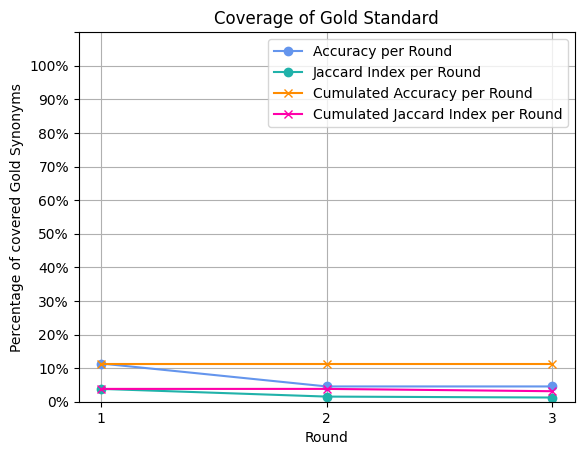

In [12]:
plt.figure()
plt.plot(np.arange(1, roundCount + 1), goldCoverageAccuracy, marker='o', color='#6495ED', label="Accuracy per Round")
plt.plot(np.arange(1, roundCount + 1), goldCoverageJaccard, marker='o', color='#20B2AA', label="Jaccard Index per Round")
plt.plot(np.arange(1, roundCount + 1), goldCumulativeCoverageAccuracy, marker='x', color='#FF8C00', label="Cumulated Accuracy per Round")
plt.plot(np.arange(1, roundCount + 1), goldCumulativeCoverageJaccard, marker='x', color='#FF00AA', label="Cumulated Jaccard Index per Round")
plt.yticks(np.arange(0, 1.2, 1 / yticks), getPercentage(1 / yticks))
plt.xticks(np.arange(1, roundCount + 1, 1))
plt.title("Coverage of Gold Standard")
plt.xlabel("Round")
plt.ylabel("Percentage of covered Gold Synonyms")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [13]:
generated_counts_per_synonym = generated.groupby([languageColumn, contentColumn, classColumn, hpoidColumn, systemColumn]).size().reset_index(name = "dummy")
distinctCounts = list(set(generated_counts_per_synonym["dummy"]))
synonymsSortedByAppearance = [[] for _ in range(0, len(distinctCounts))]
synonymsSortedByAppearanceAccuracy = [0] * len(distinctCounts)
synonymsSortedByAppearanceJaccard = [0] * len(distinctCounts)

for index, count in enumerate(distinctCounts):
    synonymsSortedByAppearance[index] = generated_counts_per_synonym[generated_counts_per_synonym["dummy"] == count][contentColumn].tolist() 

for index, appearance in enumerate(synonymsSortedByAppearance):
    synonymsSortedByAppearanceAccuracy[index]       = len(list(np.intersect1d(list(appearance), list(goldSet)))) / len(goldSet)
    synonymsSortedByAppearanceJaccard[index]        = len(list(np.intersect1d(list(appearance), list(goldSet)))) / len(set(list(goldSet) + list(appearance)))

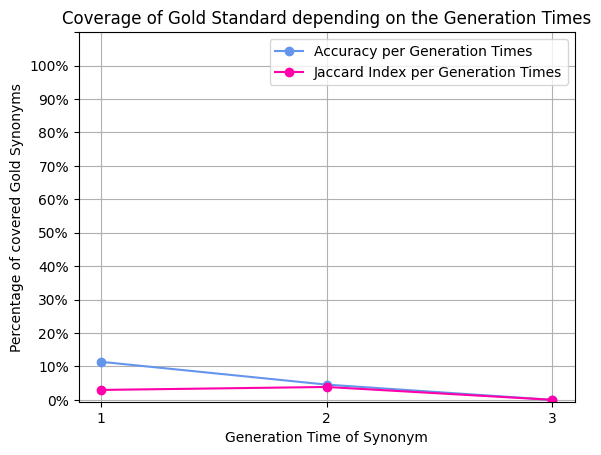

In [14]:
plt.figure()
plt.plot(np.arange(1, roundCount + 1), synonymsSortedByAppearanceAccuracy, marker='o', color='#6495ED', label="Accuracy per Generation Times")
plt.plot(np.arange(1, roundCount + 1), synonymsSortedByAppearanceJaccard, marker='o', color='#FF00AA', label="Jaccard Index per Generation Times")
plt.yticks(np.arange(0, 1.2, 1 / yticks), getPercentage(1 / yticks))
plt.xticks(np.arange(1, roundCount + 1, 1))
plt.title("Coverage of Gold Standard depending on the Generation Times")
plt.xlabel("Generation Time of Synonym")
plt.ylabel("Percentage of covered Gold Synonyms")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [15]:
generatedEmbeddings = pd.read_csv(outputFileGeneratedEmbeddings)
goldEmbeddings = pd.read_csv(outputFileGoldEmbeddings)
all = pd.concat([generatedEmbeddings, goldEmbeddings])

indexStartGold = len(generatedEmbeddings.index)

In [16]:
allEmbeddings = np.linalg.norm(all, axis=1, keepdims=True)
normalizedAllEmbeddings = all / allEmbeddings

cosine_similarity_matrix = np.dot(normalizedAllEmbeddings, normalizedAllEmbeddings.T)

In [17]:
columnHPOid = [""] * len(all.index)
for index in range(0, len(columnHPOid)):
    if index >= indexStartGold:
        columnHPOid[index] = gold.loc[index - indexStartGold, hpoidColumn]
    else:
        columnHPOid[index] = generated.loc[index, hpoidColumn]

res = []
generatedSet = list(set(generated[contentColumn].tolist()))

for index1 in range(0, indexStartGold):
    resObj = {
        "genHPO" : columnHPOid[index1],
        "goldHPO" : "",
        "similarity" : -1,
        "label" : False,
        "synonym" : False,
        "generatedTerm" : generated.loc[index1, contentColumn],
        "similarTo" : ""
    }

    if generated.loc[index1, contentColumn] in generatedSet:
        maxIndex = -1
        for index2 in range(indexStartGold, len(all.index)):
            if index1 != index2 and cosine_similarity_matrix[index1][index2] > resObj["similarity"]:
                resObj["similarity"] = cosine_similarity_matrix[index1][index2]
                maxIndex = index2


        if gold.loc[maxIndex - indexStartGold, classColumn] == exactSynonymClass:
            resObj["synonym"] = True
        else:
            if gold.loc[maxIndex - indexStartGold, classColumn] == labelClass:
                resObj["label"] = True

        resObj["similarTo"] = gold.loc[maxIndex - indexStartGold, contentColumn]

        resObj["goldHPO"] = columnHPOid[maxIndex]
        res.append(resObj)
        generatedSet.remove(generated.loc[index1, contentColumn])

In [18]:

values = {
    "exact match" : 0,
    "no match" : 0,
    "similar to label" : 0,
    "similar to synonym" : 0
}

for resObj in res:
    if float(resObj["similarity"]) > 0.975 and resObj["genHPO"] == resObj["goldHPO"]:
        if float(resObj["similarity"]) > 0.99:
            values["exact match"] = values["exact match"] + 1
            print(resObj)
        else:
            if resObj["synonym"]:
                values["similar to synonym"] = values["similar to synonym"] + 1
            else:
                if resObj["label"]:
                    values["similar to label"] = values["similar to label"] + 1
                else:
                    values["no match"] = values["no match"] + 1
    else:
        values["no match"] = values["no match"] + 1
        
print(values)

{'genHPO': 'HP:0009778', 'goldHPO': 'HP:0009778', 'similarity': 1.0000000000000002, 'label': False, 'synonym': True, 'generatedTerm': 'hypoplastic thumb', 'similarTo': 'hypoplastic thumb'}
{'genHPO': 'HP:0009778', 'goldHPO': 'HP:0009778', 'similarity': 1.0000000000000004, 'label': False, 'synonym': True, 'generatedTerm': 'thumb hypoplasia', 'similarTo': 'thumb hypoplasia'}
{'genHPO': 'HP:0000708', 'goldHPO': 'HP:0000708', 'similarity': 1.0000000000000007, 'label': False, 'synonym': True, 'generatedTerm': 'behavioural abnormality', 'similarTo': 'behavioural abnormality'}
{'genHPO': 'HP:0000708', 'goldHPO': 'HP:0000708', 'similarity': 0.9999999999999991, 'label': False, 'synonym': True, 'generatedTerm': 'behavioral abnormality', 'similarTo': 'behavioral abnormality'}
{'genHPO': 'HP:0001756', 'goldHPO': 'HP:0001756', 'similarity': 1.0000000000000007, 'label': False, 'synonym': True, 'generatedTerm': 'vestibular hypofunction', 'similarTo': 'vestibular hypofunction'}
{'genHPO': 'HP:0003189'

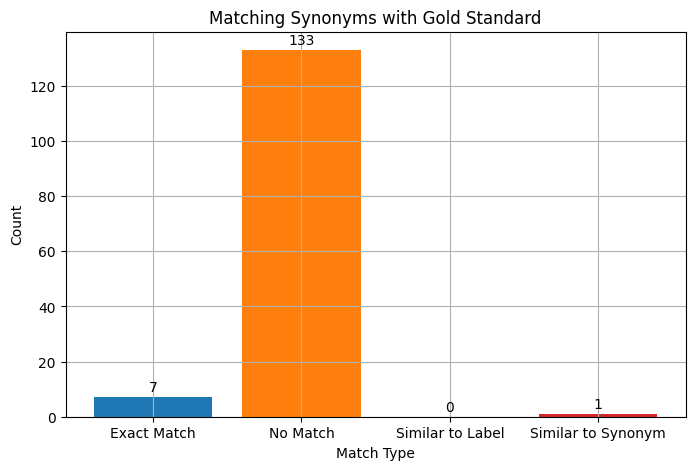

In [19]:
labels = list(values.keys())
val = list(values.values())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

plt.figure(figsize=(8, 5))
plt.bar(labels, val, color=colors)

# Add titles and labels
plt.title("Matching Synonyms with Gold Standard")
plt.xlabel("Match Type")
plt.ylabel("Count")
plt.xticks(np.arange(0, 4, 1), ["Exact Match", "No Match", "Similar to Label", "Similar to Synonym"])
plt.grid(True)

# Optional: show value on top of each bar
for i, v in enumerate(val):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

In [20]:
print(len(generated.index))
print(indexStartGold)
print(len(gold.index))

153
153
50
